# Imports and checking the data

In [10]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as T
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
print(f"On device : {device}")

On device : cuda


In [3]:
bs = 32
num_workers = os.cpu_count()

transform = T.Compose([T.Resize((32,32)), T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=num_workers)

100%|██████████| 9912422/9912422 [00:00<00:00, 113496227.99it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 102138021.77it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 28110637.16it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20617455.38it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
print(f"Count of train images: {len(trainset)}\nCount of test images: {len(testset)}")

Count of train images: 60000
Count of test images: 10000


In [5]:
img, lbl = next(iter(trainloader))

In [6]:
img.shape, lbl.shape

(torch.Size([32, 1, 32, 32]), torch.Size([32]))

# LeNet-5

In [7]:
class LeNet5(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
        nn.Tanh()
        )
    self.fc = nn.Sequential(
        nn.Linear(120, 84),
        nn.Tanh(),
        nn.Linear(84, 10),
    )

  def forward(self, x):
    x = self.layer1(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    x = F.softmax(x, dim=0)
    return x

In [8]:
model = LeNet5().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [9]:
total_step = len(trainloader)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss_sum = 0.0

    for i, (imgs, lbls) in enumerate(trainloader):
        imgs, lbls = imgs.to(device), lbls.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, lbls)
        train_loss_sum += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    train_loss_avg = train_loss_sum / len(trainloader)

    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0

    with torch.inference_mode():
        for val_imgs, val_lbls in testloader:
            val_imgs, val_lbls = val_imgs.to(device), val_lbls.to(device)
            val_outputs = model(val_imgs)
            val_loss = criterion(val_outputs, val_lbls)
            total_val_loss += val_loss.item()

            _, predicted = val_outputs.max(1)
            total += val_lbls.size(0)
            correct += predicted.eq(val_lbls).sum().item()

    val_accuracy = 100 * correct / total
    avg_val_loss = total_val_loss / len(testloader)

    print('Validation - Epoch [{}/{}], Test Loss: {:.4f}, Test Accuracy: {:.2f}%'
          .format(epoch+1, num_epochs, avg_val_loss, val_accuracy))

    print('Epoch [{}/{}], Average Train Loss: {:.4f}'
          .format(epoch+1, num_epochs, train_loss_avg))

Epoch [1/10], Step [400/1875], Train Loss: 2.3016
Epoch [1/10], Step [800/1875], Train Loss: 2.2985
Epoch [1/10], Step [1200/1875], Train Loss: 2.2907
Epoch [1/10], Step [1600/1875], Train Loss: 2.2638
Validation - Epoch [1/10], Test Loss: 2.2344, Test Accuracy: 69.51%
Epoch [1/10], Average Train Loss: 2.2873
Epoch [2/10], Step [400/1875], Train Loss: 2.1725
Epoch [2/10], Step [800/1875], Train Loss: 2.1248
Epoch [2/10], Step [1200/1875], Train Loss: 2.1269
Epoch [2/10], Step [1600/1875], Train Loss: 2.1066
Validation - Epoch [2/10], Test Loss: 2.0737, Test Accuracy: 83.53%
Epoch [2/10], Average Train Loss: 2.1378
Epoch [3/10], Step [400/1875], Train Loss: 2.0812
Epoch [3/10], Step [800/1875], Train Loss: 2.1045
Epoch [3/10], Step [1200/1875], Train Loss: 2.0432
Epoch [3/10], Step [1600/1875], Train Loss: 2.0689
Validation - Epoch [3/10], Test Loss: 2.0553, Test Accuracy: 86.58%
Epoch [3/10], Average Train Loss: 2.0658
Epoch [4/10], Step [400/1875], Train Loss: 2.0369
Epoch [4/10], Ste

# Plotting preds

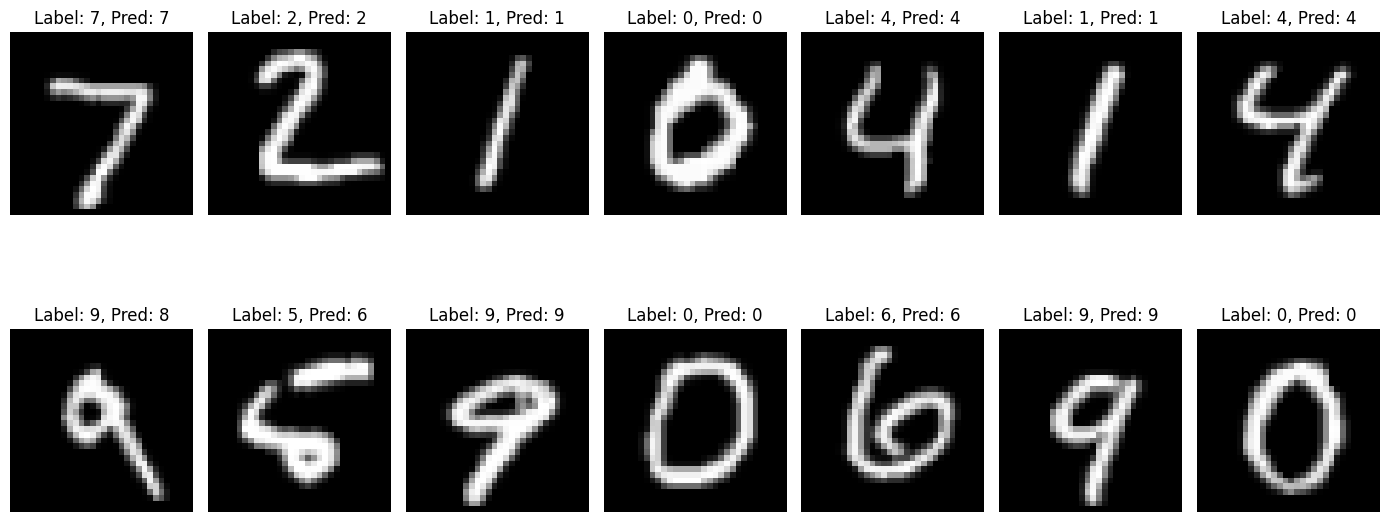

In [12]:
model.eval()

num_images = 14
data_iter = iter(testloader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

with torch.inference_mode():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

image_batch = images.cpu().numpy()
label_batch = labels.cpu().numpy()
predicted_batch = predicted.cpu().numpy()

plt.figure(figsize=(14, 7))
for idx in range(num_images):
    plt.subplot(2, 7, idx + 1)
    plt.imshow(np.transpose(image_batch[idx], (1, 2, 0)).squeeze(), cmap='gray')
    plt.title(f'Label: {label_batch[idx]}, Pred: {predicted_batch[idx]}')
    plt.axis('off')

plt.tight_layout()
plt.show()